# PRML 1.2.5-1.2.6 : Polynomial Curve Fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import unicode_literals, print_function
import six
import sys
import os
import math
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [2]:
sys.version

'3.6.0 |Anaconda 4.3.0 (x86_64)| (default, Dec 23 2016, 13:19:00) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

## generate sample dataset

In [3]:
def make_truth_data(func=lambda x: x):
    xs = np.linspace(0, 1, num=50, endpoint=True)
    ts = func(xs)
    return xs, ts

def make_observed_data(func=lambda x: x, std=0.1):
    xs = np.linspace(0, 1, num=10, endpoint=True)
    ts = func(xs) + np.random.normal(0, std, xs.size)
    return xs, ts

def sin(x):
    return np.sin(2*np.pi*x)

#def step(x):
#    return 1.0 if x >= 0.5 and x <= 1.0 else 0.0

xs_truth, ts_truth = make_truth_data(np.vectorize(sin))
xs_observ, ts_observ = make_observed_data(np.vectorize(sin), std=0.2)

In [4]:
def plot_sample(ax, xs_truth, ys_truth, xs_observ, ts_observ):
    ax.plot(xs_truth, ts_truth, label='truth')
    ax.scatter(xs_observ, ts_observ, color='green', marker='o', label='observation')
    ax.set_xlim(np.min(xs_truth), np.max(xs_truth))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.legend()
    return ax

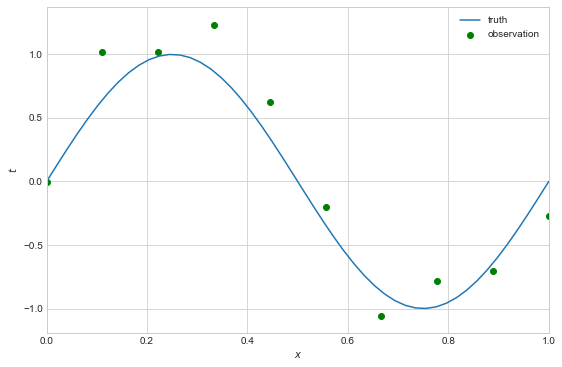

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)

## design matrix

ここでの基底関数は $\phi_{i}(x) = x^{i}$ とする

In [6]:
def poly_features(xs, m=1):
    # formula (3.16)
    return np.asarray([np.power(xs, i) for i in six.moves.range(m+1)]).transpose()

In [7]:
poly_features(xs_observ, m=3)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.11111111,  0.01234568,  0.00137174],
       [ 1.        ,  0.22222222,  0.04938272,  0.01097394],
       [ 1.        ,  0.33333333,  0.11111111,  0.03703704],
       [ 1.        ,  0.44444444,  0.19753086,  0.0877915 ],
       [ 1.        ,  0.55555556,  0.30864198,  0.17146776],
       [ 1.        ,  0.66666667,  0.44444444,  0.2962963 ],
       [ 1.        ,  0.77777778,  0.60493827,  0.47050754],
       [ 1.        ,  0.88888889,  0.79012346,  0.70233196],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [8]:
def plot_prediction(ax, ys_pred, ys_std):
    ax.plot(xs_truth, ys_pred, color='red', label='mean of predictive distribution')
    ax.fill_between(xs_truth, ys_pred-ys_std, ys_pred+ys_std,
                      color='pink', alpha=0.5, label='standard diviation of predictive distribution')
    ax.legend()
    return ax

## maximum likelihood estimation

In [9]:
class MaximumLikelihoodRegression():
    def __init__(self, basis_function=lambda x: x, m=1):
        self.basis_function = basis_function
        self.m = m
        
    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.34) or (3.15)
        self.w_ml = np.linalg.inv(phis.T.dot(phis)).dot(phis.T).dot(ts)
        # formula (3.21)
        self.std_ml = (1./phis.shape[1]) * np.sum(np.power(ts - phis.dot(model.w_ml), 2))
        
    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.31) or (1.1)
        ys = phis.dot(self.w_ml)
        return ys, self.std_ml

ys =  [ 0.00853577  0.24031408  0.44450524  0.6222449   0.77466867  0.90291218
  1.00811108  1.09140097  1.15391751  1.1967963   1.22117299  1.2281832
  1.21896256  1.1946467   1.15637125  1.10527184  1.0424841   0.96914365
  0.88638613  0.79534716  0.69716238  0.59296742  0.48389789  0.37108944
  0.25567769  0.13879827  0.02158681 -0.09482106 -0.20928972 -0.32068352
 -0.42786685 -0.52970408 -0.62505957 -0.71279769 -0.79178283 -0.86087934
 -0.9189516  -0.96486397 -0.99748084 -1.01566657 -1.01828553 -1.0042021
 -0.97228063 -0.92138551 -0.85038111 -0.75813179 -0.64350193 -0.50535589
 -0.34255806 -0.15397279]
std =  0.0860644829698


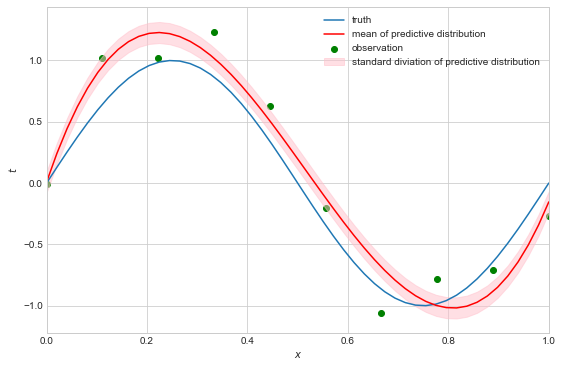

In [10]:
model = MaximumLikelihoodRegression(basis_function=poly_features, m=3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

- データに対してオーダーが大きすぎるとover fittingが発生
- 分散も非常に小さい (high bias)

ys =  [-0.00553167  1.46154616  1.87914383  1.76888676  1.45835004  1.13627595
  0.89589131  0.76817716  0.74675613  0.80588539  0.91287455  1.03608867
  1.14954642  1.23498292  1.28211481  1.28772324  1.25405692  1.18695377
  1.09398485  0.98283897  0.86008997  0.73042175  0.59632835  0.45825786
  0.31512934  0.16512225  0.00661658 -0.16084962 -0.33574096 -0.51393287
 -0.68848003 -0.84983302 -0.98655638 -1.08655802 -1.13878654 -1.13529139
 -1.07346919 -0.95823902 -0.80379986 -0.63452422 -0.48443382 -0.39458584
 -0.40757147 -0.55819268 -0.8592381  -1.28112435 -1.72400593 -1.98078371
 -1.68926032 -0.27149932]
std =  8.0419285962e-09


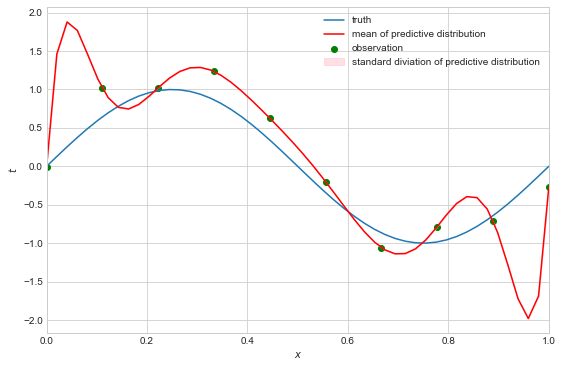

In [11]:
model = MaximumLikelihoodRegression(basis_function=poly_features, m=9)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

## maximum posterior estimation

結果としては正則化最小二乗法 (§3.1.4) と同様らしいのでその通りに実装 (これで合っている?)

In [12]:
class MaximumPosteriorRegression():
    def __init__(self, basis_function=lambda x: x, m=1, lmd=1):
        self.basis_function = basis_function
        self.m = m
        self.lmd = lmd
    
    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.28)
        self.w_map = np.linalg.inv(self.lmd * np.identity(phis.shape[1]) + phis.T.dot(phis)).dot(phis.T).dot(ts)
        # formula (3.29) or (1.67)
        self.std_map = (1./phis.shape[1]) * np.sum(np.power(ts - phis.dot(model.w_map), 2)) \
                            + (self.lmd/2.) * np.sum(np.power(self.w_map, 2))
        
    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.31) or (1.1)
        ys = phis.dot(self.w_map)
        return ys, self.std_map

ys =  [ 0.35856361  0.48934934  0.60306801  0.70041996  0.78210555  0.84882512
  0.90127903  0.94016763  0.96619126  0.98005027  0.98244502  0.97407585
  0.95564311  0.92784716  0.89138834  0.84696701  0.7952835   0.73703818
  0.67293139  0.60366348  0.52993481  0.45244571  0.37189655  0.28898767
  0.20441942  0.11889214  0.0331062  -0.05223806 -0.13644029 -0.21880015
 -0.29861727 -0.37519132 -0.44782193 -0.51580877 -0.57845148 -0.63504972
 -0.68490312 -0.72731135 -0.76157405 -0.78699088 -0.80286148 -0.8084855
 -0.8031626  -0.78619242 -0.75687461 -0.71450883 -0.65839473 -0.58783195
 -0.50212015 -0.40055897]
std =  0.539595008421


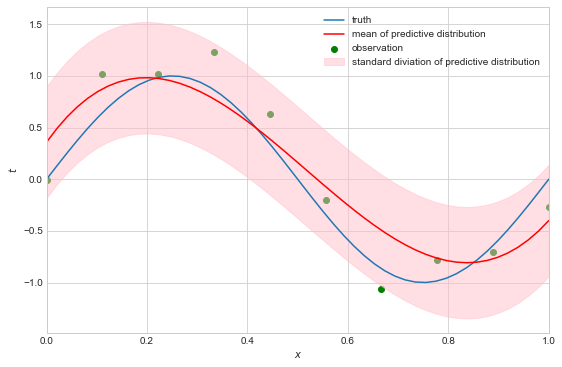

In [13]:
model = MaximumPosteriorRegression(basis_function=poly_features, m=3, lmd=1e-3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

- データに対してオーダーが大きくても事前分布(≒正則化)の導入でover fittingを防ぐことができる
- ただし，ベイズ推定のようにパラメータの事後分布を求めている訳ではないので，outlierに弱い場合があるらしい
  - http://ibisforest.org/index.php?MAP推定

ys =  [ 0.22433654  0.36079427  0.48614861  0.60015755  0.70259523  0.79325522
  0.87195416  0.93853572  0.99287496  1.03488302  1.06451219  1.08176121
  1.08668105  1.07938072  1.06003347  1.02888301  0.98624981  0.93253737
  0.86823829  0.79394004  0.71033025  0.61820144  0.5184548   0.41210299
  0.30027159  0.18419899  0.0652344  -0.05516637 -0.17544765 -0.29396369
 -0.40899167 -0.5187487  -0.62141298 -0.71514987 -0.79814335 -0.86863338
 -0.92495997 -0.96561449 -0.98929893 -0.99499398 -0.98203664 -0.95020823
 -0.89983363 -0.8318928  -0.74814546 -0.65127006 -0.54501794 -0.43438408
 -0.32579541 -0.22731799]
std =  0.213809167815


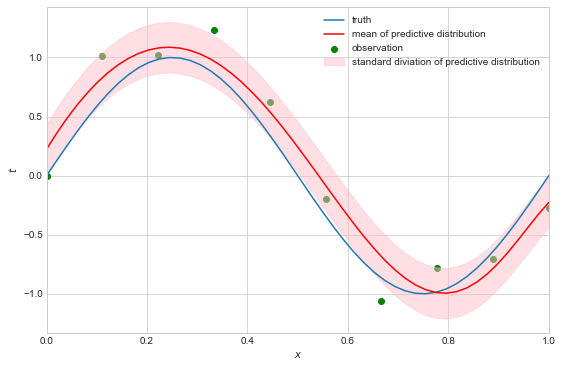

In [14]:
model = MaximumPosteriorRegression(basis_function=poly_features, m=9, lmd=1e-3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

## bayesian inference

In [15]:
class BayesianRegression():
    def __init__(self, basis_function=lambda x: x, m=1, alpha=1., beta=1.):
        self.basis_function = basis_function
        self.m = m
        self.alpha = alpha
        self.beta = beta

    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.53) or (1.72)
        var_inv = self.alpha * np.identity(phis.shape[1]) + self.beta * phis.T.dot(phis)
        self.var = np.linalg.inv(var_inv) 
        # formula (3.54) or (1.70)
        self.mean = self.beta * self.var.dot(phis.T.dot(ts))

    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.58)
        pred_mean = phis.dot(self.mean)
        # formula (3.59)
        pred_var = (1./self.beta) + np.sum(phis.dot(self.var.dot(phis.T)), axis=1)
        pred_std = np.sqrt(pred_var)
        return pred_mean, pred_std

$\alpha$ はテキスト通り $5 \times 10^{-3}$，$\beta$ はサンプルの標準偏差 $\sigma$ とすると $1 / (\sigma^{2})$ とした

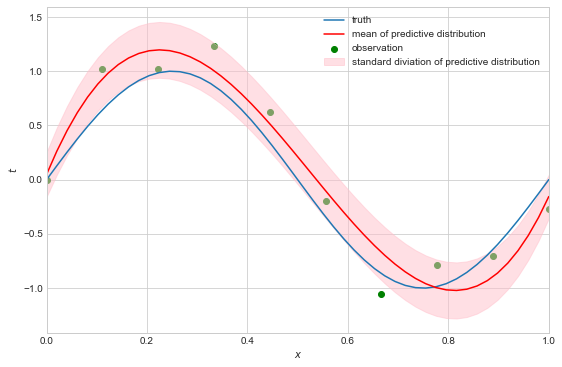

In [16]:
model = BayesianRegression(basis_function=poly_features, m=4, alpha=5e-3, beta=100)
model.fit(xs_observ, ts_observ)
pred_mean, pred_std = model.predict(xs_truth)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, pred_mean, pred_std)